# Preliminary EDA wearing masks

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
import datetime
import functions

sns.set_style("whitegrid")
warnings.filterwarnings(action='ignore')
pd.set_option('display.max_columns', None) # To display all columns

### Read in data

In [3]:
# Reading in data files from csv into a dictionary of dataframes.
dfs_region = functions.get_data("data/CMU_Global_data/Full_Survey_Data/region/smooth/", "region")

# Concatenating individuals dataframes from the dictionary into one dataframe for regions.
regions = pd.concat(dfs_region)

Read in data completed.


### Data cleaning

In [4]:
print('regions:', regions.shape)

regions: (1564190, 118)


In [5]:
print('Columns including the words mask and weighted:')
print(regions.columns[(regions.columns.str.contains("mask") & (regions.columns.str.contains("weighted")))])

Columns including the words mask and weighted:
Index(['smoothedpct_wear_mask_all_time_weighted',
       'smoothed_pct_wear_mask_most_time_weighted',
       'smoothed_pct_wear_mask_half_time_weighted',
       'smoothed_pct_wear_mask_some_time_weighted',
       'smoothed_pct_wear_mask_none_time_weighted',
       'smoothed_pct_wear_mask_all_time_weighted'],
      dtype='object')


There are two similar columns, if there's a number in the one column, it is NaN in the other, so the NaN's in the column 'smoothed_pct_wear_mask_all_time_weighted' get updated with the numbers of the 'smoothedpct_wear_mask_all_time_weighted' column.

In [ ]:
def deal_with_NaNs_masks(df):
    '''Updates NaN's in smoothed_pct_wear_mask_all_time_weighted with numbers from smoothedpct_wear_mask_all_time_weighted.'''
    # Updating NaN's in the smoothed_pct column with numbers from the smoothedpct column.
    df_to_update = df[['smoothedpct_wear_mask_all_time_weighted','smoothed_pct_wear_mask_all_time_weighted']]
    print('NaNs before update:', df_to_update['smoothed_pct_wear_mask_all_time_weighted'].isna().sum())
    df_to_update['smoothed_pct_wear_mask_all_time_weighted'].update(df_to_update['smoothedpct_wear_mask_all_time_weighted'])
    print('NaNs after update:', df_to_update['smoothed_pct_wear_mask_all_time_weighted'].isna().sum())
    # drop these two columns from the df regions
    df.drop(columns='smoothedpct_wear_mask_all_time_weighted', axis=1, inplace=True)
    # add the 'smoothed_pct_wear_mask_all_time_weighted' column from df_to_update to the regions set
    df['smoothed_pct_wear_mask_all_time_weighted'] = df_to_update['smoothed_pct_wear_mask_all_time_weighted']
    print('Updated.')
    df = df[df['smoothed_pct_cli'].notna()]
    return df

In [ ]:
# create a new dataframe for data on masks
def create_df_masks(df):
    '''Function to create a data frame for data on masks.'''
    df_masks = df[["country_agg","GID_0","region_agg","GID_1","country_region_numeric","gender","age_bucket","smoothed_pct_cli","date","month"]]
    mask_names = df.columns[(df.columns.str.contains("mask") & (df.columns.str.contains("weighted")))]

    for i in mask_names:
        df_masks[str(i)] = df[str(i)]
    
    return df_masks

In [7]:
df_update = functions.deal_with_NaNs_masks(regions)
df_regions = functions.insert_month(df_update)
df_masks = functions.create_df_masks(df_regions)

NaNs before update: 1100684
NaNs after update: 0
Updated.
Created month column.


In [8]:
# number of unique data values per column.
for i in df_masks.columns:
    print('Unique values in', i, df_masks[str(i)].nunique())

Unique values in country_agg 116
Unique values in GID_0 116
Unique values in region_agg 1692
Unique values in GID_1 1692
Unique values in country_region_numeric 2126
Unique values in gender 4
Unique values in age_bucket 4
Unique values in smoothed_pct_cli 2412
Unique values in date 183
Unique values in month 7
Unique values in smoothed_pct_wear_mask_most_time_weighted 5706
Unique values in smoothed_pct_wear_mask_half_time_weighted 4205
Unique values in smoothed_pct_wear_mask_some_time_weighted 4775
Unique values in smoothed_pct_wear_mask_none_time_weighted 9910
Unique values in smoothed_pct_wear_mask_all_time_weighted 9959


### Belgium, France, Netherlands and Germany

In [9]:
# create a new data frame with Belgium, France, the Netherlands and Germany.
be_fr_nl_ger = ['Belgium','France','Netherlands','Germany']
df_bfgn = df_masks[df_masks['country_agg'].str.contains('|'.join(be_fr_nl_ger))]

### Mask wearing and COVID-like-symptoms by country
Conclusion: the Netherlands is really bad at mask wearing, but has less inhabitants with COVID-like symptoms than France and Belgium. As the number of cases in the Netherlands surged again, mask wearing was introduced.

<AxesSubplot:xlabel='date', ylabel='smoothed_pct_cli'>

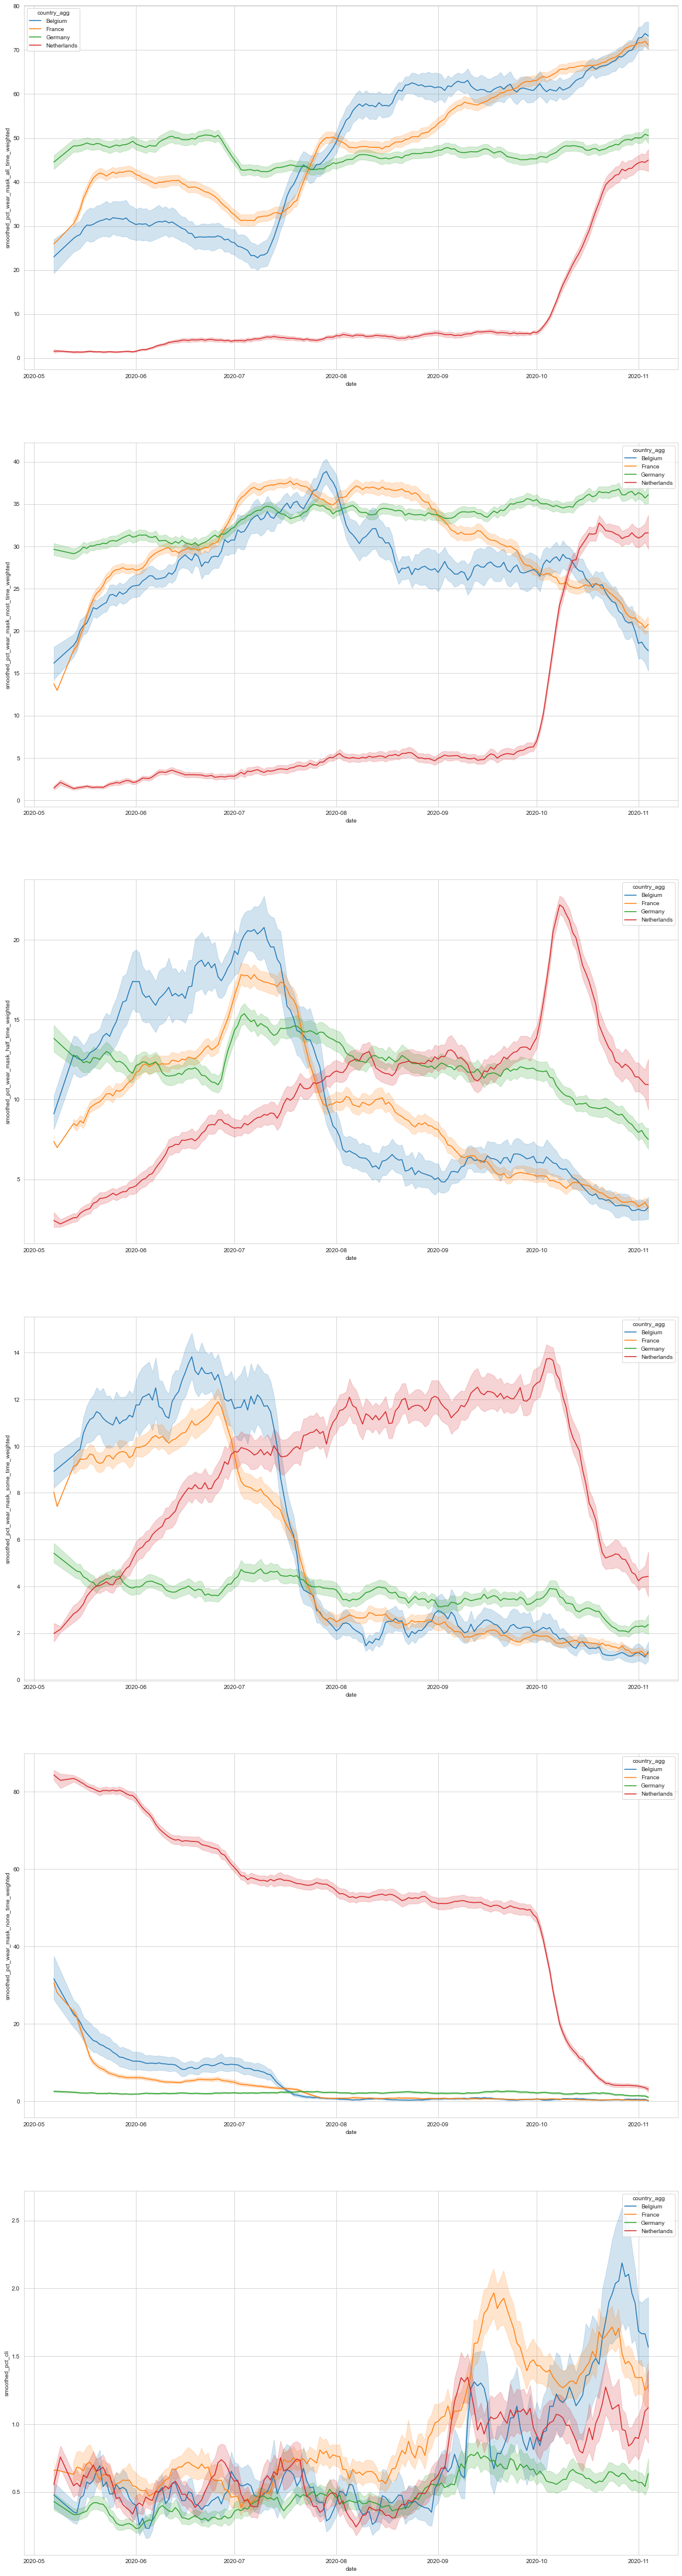

In [10]:
f, axes = plt.subplots(6,1, figsize=(20,80))
sns.lineplot(data=df_bfgn, x="date", y="smoothed_pct_wear_mask_all_time_weighted", hue="country_agg", ax=axes[0])
sns.lineplot(data=df_bfgn, x="date", y="smoothed_pct_wear_mask_most_time_weighted", hue="country_agg", ax=axes[1])
sns.lineplot(data=df_bfgn, x="date", y="smoothed_pct_wear_mask_half_time_weighted", hue="country_agg", ax=axes[2])
sns.lineplot(data=df_bfgn, x="date", y="smoothed_pct_wear_mask_some_time_weighted", hue="country_agg", ax=axes[3])
sns.lineplot(data=df_bfgn, x="date", y="smoothed_pct_wear_mask_none_time_weighted", hue="country_agg", ax=axes[4])
sns.lineplot(data=df_bfgn, x="date", y="smoothed_pct_cli", hue="country_agg", ax=axes[5])

### Mask wearing and COVID-like-symptoms by gender
Conclusion: females wear masks more often than males, but there is no difference between both genders in number of cases with COVID-like symptomes.

How many datapoints are there for 'other' gender?

In [11]:
df_bfgn.gender.value_counts()

overall    30490
female     29584
male       28553
other        221
Name: gender, dtype: int64

Consider excluding 'other' gender.

In [12]:
# excluding 'other' gender, because there are too few data points.
df_bfgn_gender = df_bfgn[df_bfgn['gender']!='other']

<AxesSubplot:xlabel='date', ylabel='smoothed_pct_cli'>

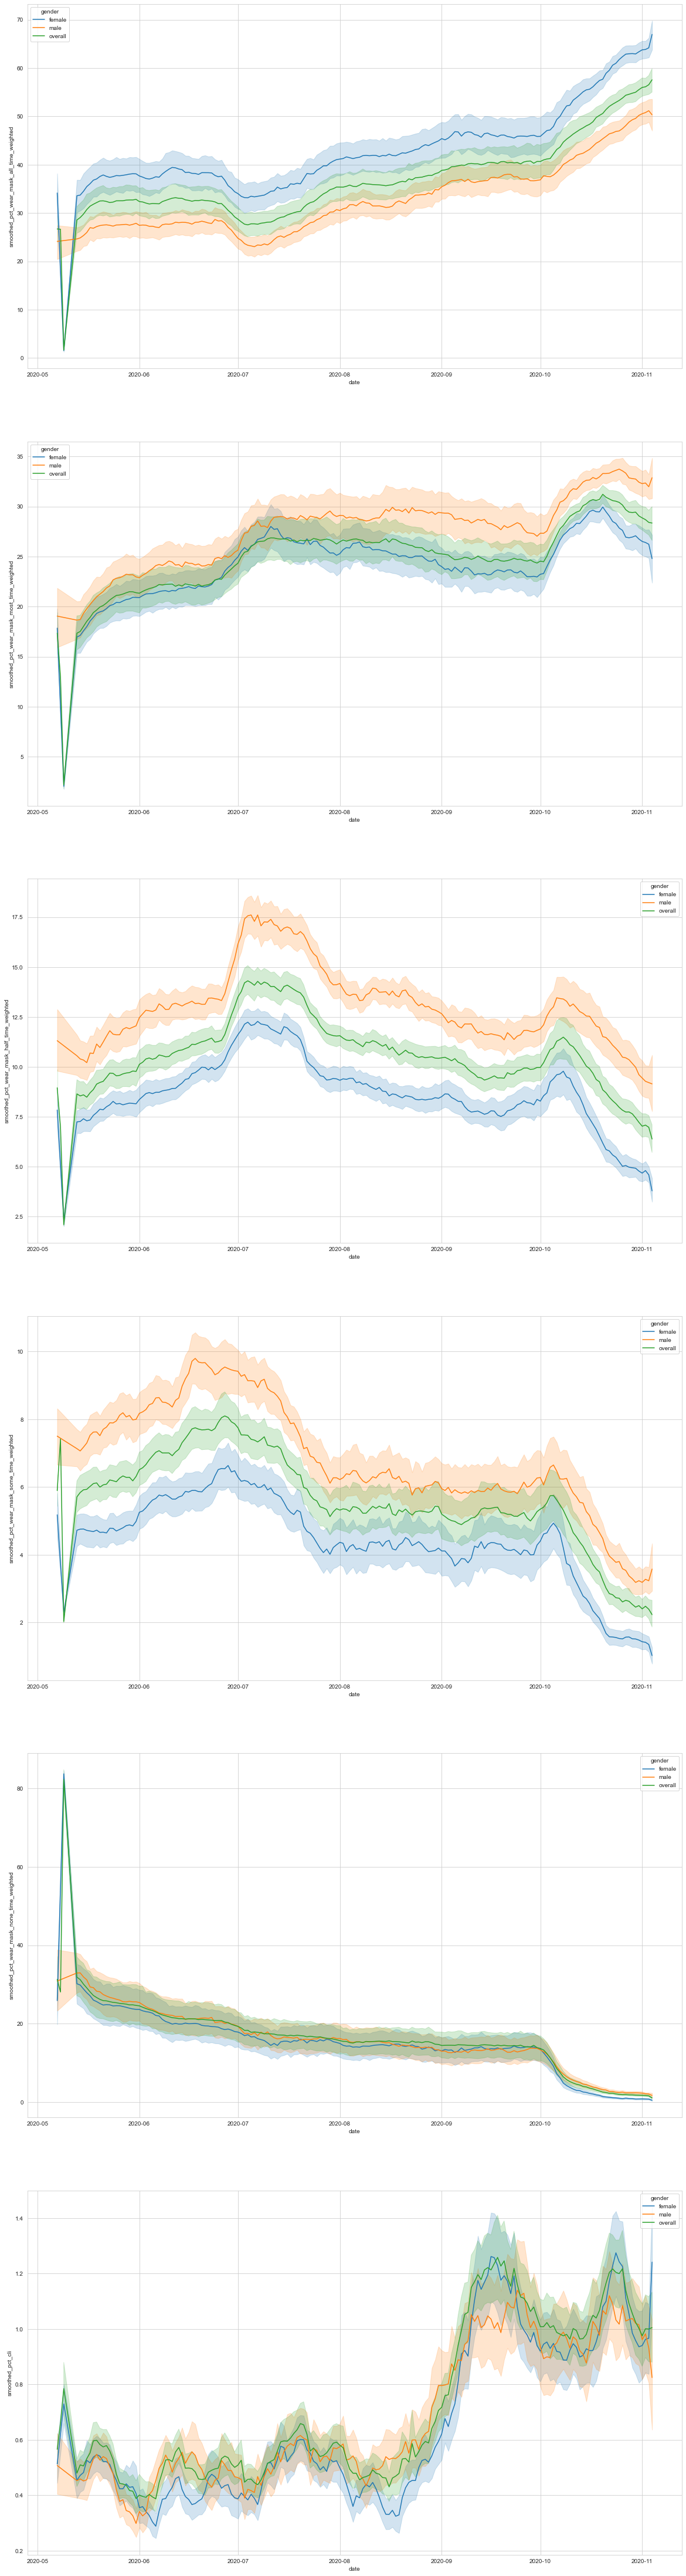

In [13]:
f, axes = plt.subplots(6,1, figsize=(20,80))
sns.lineplot(data=df_bfgn_gender, x="date", y="smoothed_pct_wear_mask_all_time_weighted", hue="gender", ax=axes[0])
sns.lineplot(data=df_bfgn_gender, x="date", y="smoothed_pct_wear_mask_most_time_weighted", hue="gender", ax=axes[1])
sns.lineplot(data=df_bfgn_gender, x="date", y="smoothed_pct_wear_mask_half_time_weighted", hue="gender", ax=axes[2])
sns.lineplot(data=df_bfgn_gender, x="date", y="smoothed_pct_wear_mask_some_time_weighted", hue="gender", ax=axes[3])
sns.lineplot(data=df_bfgn_gender, x="date", y="smoothed_pct_wear_mask_none_time_weighted", hue="gender", ax=axes[4])
sns.lineplot(data=df_bfgn_gender, x="date", y="smoothed_pct_cli", hue="gender", ax=axes[5])

### Mask wearing and COVID-like-symptoms by age bucket
Conclusion: younger adults wear masks more often then older adults. After summer, when the semester at university started again, the number of cases with COVID-like illness among younger adults surged.

<AxesSubplot:xlabel='date', ylabel='smoothed_pct_cli'>

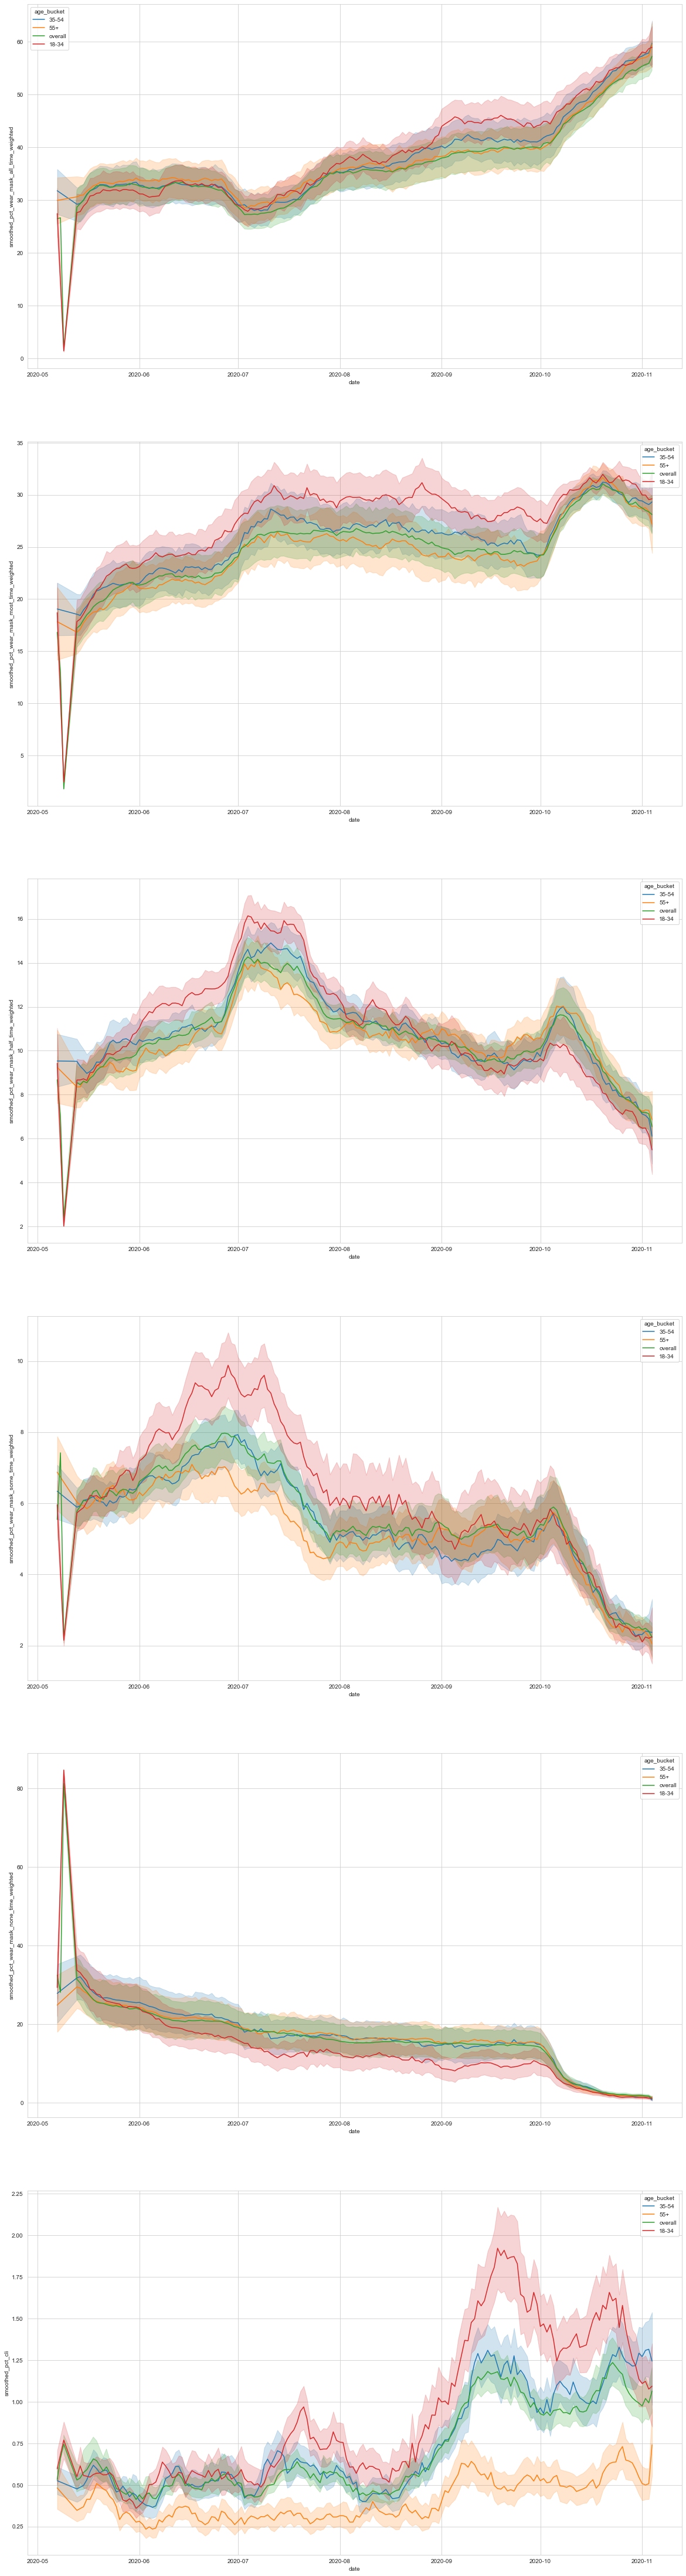

In [14]:
f, axes = plt.subplots(6,1, figsize=(20,80))
sns.lineplot(data=df_bfgn, x="date", y="smoothed_pct_wear_mask_all_time_weighted", hue="age_bucket", ax=axes[0])
sns.lineplot(data=df_bfgn, x="date", y="smoothed_pct_wear_mask_most_time_weighted", hue="age_bucket", ax=axes[1])
sns.lineplot(data=df_bfgn, x="date", y="smoothed_pct_wear_mask_half_time_weighted", hue="age_bucket", ax=axes[2])
sns.lineplot(data=df_bfgn, x="date", y="smoothed_pct_wear_mask_some_time_weighted", hue="age_bucket", ax=axes[3])
sns.lineplot(data=df_bfgn, x="date", y="smoothed_pct_wear_mask_none_time_weighted", hue="age_bucket", ax=axes[4])
sns.lineplot(data=df_bfgn, x="date", y="smoothed_pct_cli", hue="age_bucket", ax=axes[5])